### Import Libraries

In [49]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import spacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from afinn import Afinn
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

### Data Collection & Preprocessing

In [2]:
data=pd.read_csv('reviews.csv')

#### Lower Case

In [3]:
data["content"] = data["content"].str.lower()

#### Removing links

In [4]:
data['content'] = data['content'].fillna('')

In [5]:
no_url=[]
for sentence in data["content"]:
    no_url.append(re.sub(r"http\S+", "", sentence))
data["content"]=no_url

#### Remove next lines

In [6]:
data['content'] = data['content'].str.replace('\n', '')

#### Removing words containing numbers

In [7]:
pattern = r'\b\w*\d\w*\b'
def remove_words_with_numbers(text):
    return re.sub(pattern, '', text)
data['content'] = data['content'].apply(remove_words_with_numbers)

#### Removing extra spaces

In [8]:
data['content'] = data['content'].apply(lambda x: ' '.join(x.split()))

#### Removing special characters

In [9]:
no_special_char=[]
for sentence in data.content:
    no_special_char.append(re.sub('[^A-Za-z0-9]+', ' ', sentence))
data["content"]=no_special_char

#### Removal of stop words

In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
def remove_stopwords(text):
    tokens = text.split()
    filtered_text = [word for word in tokens if word.lower() not in stop_words]
    return ' '.join(filtered_text)

In [12]:
data['content'] = data['content'].apply(remove_stopwords)

#### Stemming

In [13]:
stemmer = PorterStemmer()

In [14]:
def stem_text(text):
    # Initialize Porter Stemmer
    stemmer = PorterStemmer()
    # Tokenize the text and apply stemming to each word
    stemmed_words = [stemmer.stem(word) for word in word_tokenize(text)]
    # Join the stemmed words back into a sentence
    stemmed_text = ' '.join(stemmed_words)
    return stemmed_text

In [15]:
data['content'] = data['content'].apply(stem_text)

#### Lemmatization

In [16]:
nlp = spacy.load('en_core_web_sm')

In [17]:
def lemmatize_text(text):
    # Process the text with spaCy
    doc = nlp(text)
    # Extract lemmatized tokens
    lemmatized_tokens = [token.lemma_ for token in doc]
    # Join the lemmatized tokens into a sentence
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

In [18]:
data['content'] = data['content'].apply(lemmatize_text)

In [19]:
print(data['content'][0])

recur task everi day need list remind buzz time problem app remind time somehow start drift everi day give differ time next day annoy fail screw go elsewher find well app let guy know updat suggest work find app drift move


### Data Visualization

#### Word Cloud

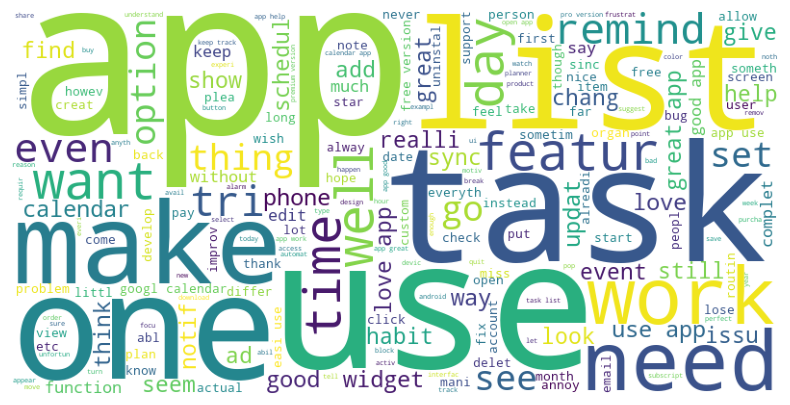

In [20]:
text_data = ' '.join(data['content'].dropna())

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400,max_words=200, background_color='white').generate(text_data)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Frequency Table

In [21]:
# Tokenize the text into words
words = text_data.split()
# Count the frequency of each word
word_freq = Counter(words)
# Convert the frequency table to a DataFrame
frequency_table = pd.DataFrame.from_dict(word_freq, orient='index', columns=['Frequency'])
# Sort the DataFrame by frequency in descending order
frequency_table = frequency_table.sort_values(by='Frequency', ascending=False)
# Display the frequency table
# print(frequency_table)
frequency_table.head(15)

,Frequency
app,16380
use,6881
task,6481
time,4203
like,4116
work,3729
list,3442
good,3263
would,3226
calendar,3224


#### Bar Graph

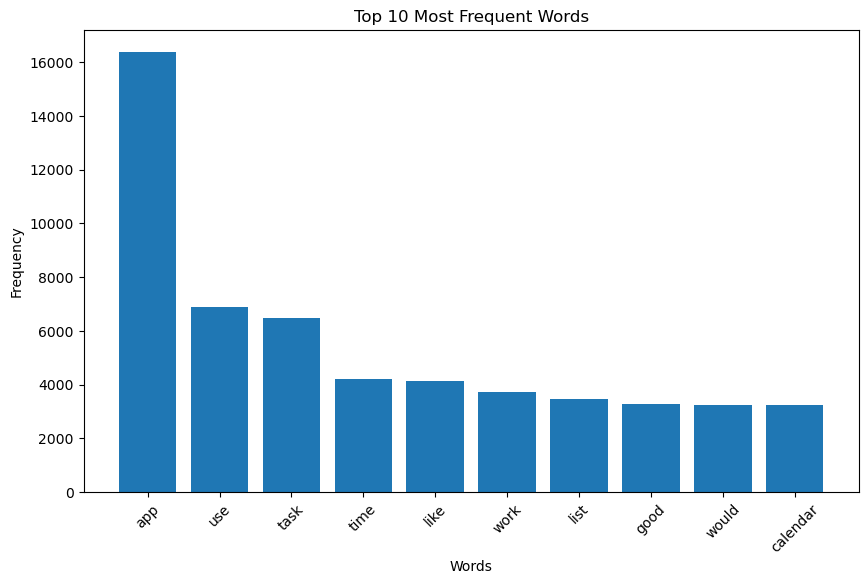

In [22]:
top_10_words = frequency_table.head(10)
plt.figure(figsize=(10, 6))
plt.bar(top_10_words.index, top_10_words['Frequency'])
plt.title('Top 10 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.show()

### Sentiment Analysis

#### Using Afinn Library

In [23]:
afinn = Afinn()
content_column = data['content']

In [24]:
def analyze_sentiment(text):
    words = text.split()
    sentiment_score = sum(afinn.score(word) for word in words)
    if sentiment_score > 0:
        return "Positive"
    elif sentiment_score < 0:
        return "Negative"
    else:
        return "Neutral"

In [25]:
data['Sentiment_afinn'] = content_column.apply(analyze_sentiment)

In [26]:
print(data[['content', 'Sentiment_afinn']].head())

                                             content Sentiment_afinn
0  recur task everi day need list remind buzz tim...        Negative
1  instead shop around download wide use set one ...        Positive
2  everi blue app ask updat acct email everyth ta...        Negative
3  terribl updat app use perfect plan certain tas...        Positive
4  app deceivingli terribl realli nice design fea...        Positive


#### Using VADER Library

In [27]:
def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    if sentiment_dict['compound'] >= 0.05 :
        return "Positive"
    elif sentiment_dict['compound'] <= - 0.05 :
        return "Negative"
    else :
        return "Neutral"

#### Data Visualization

In [28]:
data['Sentiment_vader'] = data['content'].apply(sentiment_scores)

In [29]:
print(data[['content', 'Sentiment_vader']].head())

                                             content Sentiment_vader
0  recur task everi day need list remind buzz tim...        Negative
1  instead shop around download wide use set one ...        Positive
2  everi blue app ask updat acct email everyth ta...        Negative
3  terribl updat app use perfect plan certain tas...        Positive
4  app deceivingli terribl realli nice design fea...        Positive


In [43]:
sentiment_counts = data['Sentiment_afinn'].value_counts()

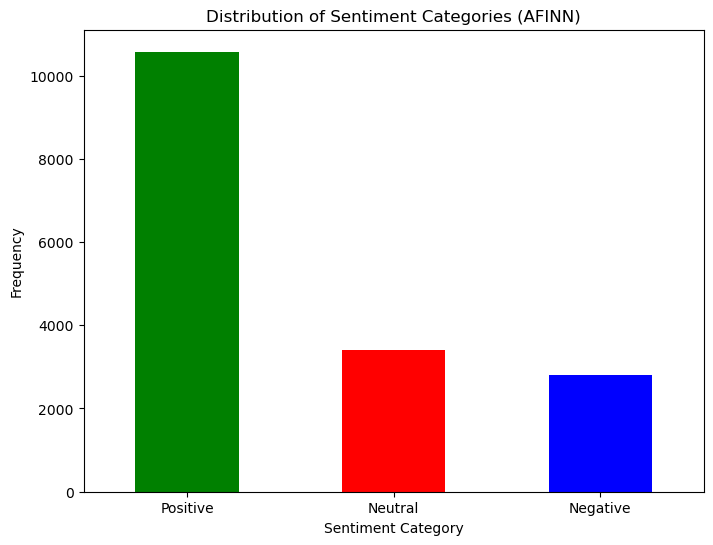

In [53]:
# Create a bar plot to visualize the distribution of sentiment categories
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Categories (AFINN)')
plt.xticks(rotation=0)  
plt.show()

In [45]:
sentiment_counts_vader = data['Sentiment_vader'].value_counts()

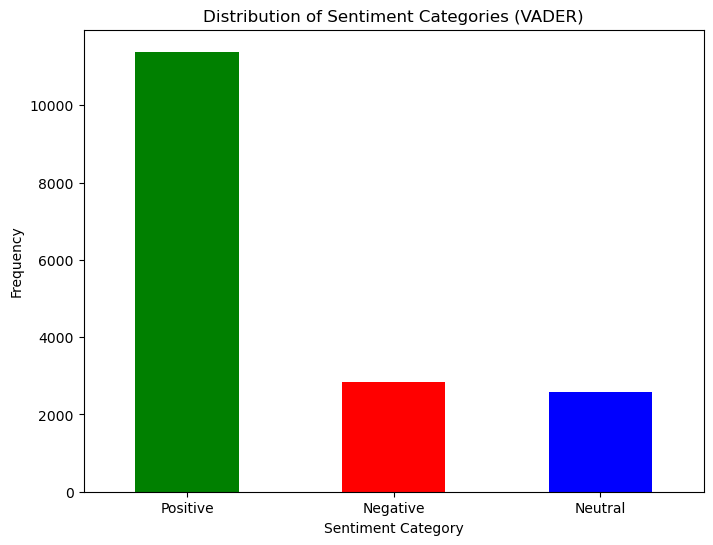

In [47]:
plt.figure(figsize=(8, 6))
ax = sentiment_counts_vader.plot(kind='bar', color=['green', 'red', 'blue'])
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Categories (VADER)')
plt.xticks(rotation=0)
plt.show()